## Code Authors
Özgür Aslan 2236958 aslan.ozgur@metu.edu.tr  
Burak Bolat 2237097 burak.bolat@metu.edu.tr

## Paper Authors

Mahmoud Afifi, Marcus A. Brubaker, Michael S. Brown

## Paper Information Summary
The paper we selected to implement is [HistoGAN: Controlling Colors of GAN-Generated and Real Images via Color Histograms](https://arxiv.org/abs/2011.11731) (CVPR, 2021).   

The main idea of the paper is to use color histogram of target images to control the colors of the generated image without changing the high level features of the generated image (gender, having glasses, beard, hair style and objects in the background...)  
To accomplish this idea, they modify the StyleGAN2 architecture:
- In the last 2 style blocks, instead of using affine transformation of the w vector, they use the color histogram projected by a neural network.
- In addition to mixing, path length and r1 regularizations, they use a histogram based loss.
- Two different target images are used to obtain a interpolated histogram. This histogram is used by the generator network to control the generated image's color scheme. 
- Interpolation of histograms is used to prevent the generator network to overfit color histograms of the training dataset.
- Due to hardware limitations, image resolution of 256 is used.
- Also due to hardware limitations they use batches of size 2 with gradient accumulation.

### Histogram Usage with the SytleGAN2 Architecture 
![arch](materials/arch.png)

## Experimental Goals
This study implements only the HistoGAN part of the paper, not ReHistoGAN.
Our experimental result goal is to train HistoGAN to generate Anime Faces with controlled histograms and compute the FID scores given in the paper.

![exp1](materials/expg1.jpeg)
![exp2](materials/expg2.jpeg)

### Histogram Computation
Computing Histogram is critical since it directly affects style of last 2 blocks. Authors used chrominance logarithm space. It normalizes each color channel with respect to other two channels in logarithmic space. In this chrominance space, there is u and v axes. That is, if we look at red channel's chrominance space, u is the normalization of red channel with respect to green and v is the normalization of red channel with respect to blue. Same holds for all color channels.  

For red channel: $I_{uR}(x) = log(\dfrac{I_R(x)+\epsilon}{I_G(x)+\epsilon}$)

After shifting RGB space to RGB-uv space, the histogram is computed as it is computationally efficient and more stable. Authors used 64 bin for the histogram which results in 64x64 histogram for u and v channel. We have 3 channels, namely red, green and blue, thus, overall the histogram is 3x64x64. Histogram is weighted with respect to pixel intesity $I_y$, i.e. if a pixel has high RGB values its affect on the histogram bin is higher.   

$I_y(x) = \sqrt{I_R^2(x) + I_G^2(x) + I_B^2(x)}$

Last difference of the histogram than histograms of previous works is kernels for computing bins. Authors do not used exact bin selection. Instead, they put a normalized pixel into a bin with respect to soft kernel. That means, if we have a red channel after normalized with respect to green and blue, we have some u and v values. Instead of just adding 1 (1 being chosen for simplicty, remember intensity multiplication) to the bin of H(u,v), they add values to the neighbour of (u,v) with the value after inverse quadratic kernel.

$H(u,v,c) = \sum_{x} k(I_{uc}(x), I_{vc}(x), u, v)I_y(x)$  
$k(I_{uc}, I_{vc}, u, v) = (1 + (|I_{uc}-u|/\tau)^2)^{-1}\times(1 + (|I_{uc}-u|/\tau)^2)^{-1}$

Histogram feature is computed like syle vector (w). It passed through the same neural network architecture with different parametes. More precisely, histogram passes through 8 layer MLP and outputs latent histogram vector size of 512.  

We put some computed histograms by us. Images taken from internet crawling.  

### Loss for Training with Histogram
Since the paper uses target histogram for generation, generated image should have close histogram to target. Thus a closeness measure Hellinger distance between histogram of generated and target images is computed and tried to minimize. You can check the losses belove.

Difference between histograms  

$C(H_g, H_t) = \dfrac{1}{\sqrt{2}} ||H_g^{\frac{1}{2}} - H_t^{\frac{1}{2}}||_2$

$L_g = D(I_g) + \alpha C(H_g, H_t)$
Total loss for generator  

### Discriminator

Discriminator consist of residual blocks. There are log_2(N)-1 such bloks where N is image resolution, to be spesific 256. As a result, the discriminator has 7 layers. First block takes 3 channel image as input and outputs m channel features. After the first block, each block produces 2*m of previous block. At the end of residual blocks, a FC layer outputs a scaler.

![res](materials/residual.png)


### Important Note on Dataset
The Anime Face Dataset is a Kaggle dataset, thus, requires a Kaggle account. Using an account one can download it from:
https://www.kaggle.com/datasets/splcher/animefacedataset

### Faced Challenges

#### Architecture Challenges

As we stated, HistoGAN is built on StyleGAN2. StyleGAN2 scales directly the weigth of the model, unlike the first version does the nearly same operations, namely mod-demod, on convolved image (or say not directly weights for convoltion filters). The original StyleGAN2 implemented using Tensorflow which allows to multiplication on weights, that is called in-place operation on variables. However, Pytorch does not allow in-place operations on built in modules like torch.nn.Conv2d. Therefore, we implemented a conv2d version. Model parameters are Pytorch Variables and convolution operation is handled with fold and unfold operations of Pytorch. Doing so we can apply convolution after scaling weights of convolution filters.


#### Training Challenges

During the training phase, the paper does not mentioned how generator outputs the images. We made different assumption such as using sigmoid or tanh to generate pixels in a range. Another assumption for the same problem is using ReLU or leaky ReLU that we saw from other generator implementation.  
StyleGAN2 stated that they used non saturating loss for some datasets and WGAN-GP loss for other datasets. HistoGAN paper does not clearly mention on this. Consequently, we implemented both but non saturating loss lead numerical issues like nan or infs. On the other hand, WGAN-GP computes high loss values and results in rapid saturation (see above figures). This issues may be resulted from hand implemented convolution operations. 

#### Ambigious Loss

The paper does not state clearly which loss functions for both generator and discriminator is used. It states how one can combine with histogram loss, but, exact losses are not clear. As a result, we accounted three discriminator losses. We focused mostly non saturating losses since it was mentioned in the paper. 

We implemented gradient penalty and R1 penalty for Discriminator. R1 penalty is the gradient penalty for only scoring the real images. Seeing both penalty does not reach good performance, we trained the Discriminator with Spectral Normalization. 

#### Model Initialization  

The model initalization was unclear. StyleGAN2 initializes weights with random normal and uses equalized learning rate method, however, initalization with kaiming may also be used. Authors granted the arhitecture from StyleGAN2, yet, they do not fully copy the training details. As a consequence, they do not mentioned that they used equalized learning rate. We implemented kaiming normal implementation and equalized learning rate, however, there was no such important improvements. As a result, we stick with kaiming normal.

#### Training with Different Architectures

Since we can not reach the desired generated images, we implemented StyleGANv1 + HistoGAN Block and a slight changed version of StyleGANv1 which was mentioned in StyleGAN2 paper (please see revisede StyleGAN in StyleGAN2 paper). We implemented all versions given at the figure below.

![archs](materials/archs.png)

#### Implementation Info
- python 3.7.13
- pytorch 1.11.0 with cuda10.2   
Please install 
- torch-optimizer for DiffGrad optimizer
- torchmetrics and torchmetrics[image] for FID score computation
#### Model Flow
- Get image batch and create histograms.
- Mix random two histogram and give it to the generator as target histogram. 
- Create random noise and give it to the generator.
- Random noise is passed through the style network which is 8 layer Linear network and get style vector.
- Style vector is linearly transformed for the corresponding block, then, weights are moduleted and demoduleted with block's weights.
- At the first block, learnable constant feature is convolved with weights processed at previous step. Paddings are set not to change block's input feature size.
- Convolution bias and linearly projected random noise (B) are added to the convolved feature.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
from trainer import Trainer
from torchvision.utils import save_image

/home/kovan/anaconda3/envs/histo/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    imgs = imgs.mul(255).add_(0.5).clamp_(0, 255).to("cpu", torch.uint8)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        plt.show()

In [3]:
config = dict(
    num_epochs = 10, # number of epochs for training
    batch_size = 8, # batch size
    acc_gradient_total = 8, # total number of samples seen by the networks in 1 iteration
    r1_factor = 10, # coefficient of the r1 regularization term
    r1_update_iter = 4, # in every r1_update_iter r1 regularization is used
    decay_coeff = 0.99, # ema decay coefficient for updating the path length target varaible
    plr_update_iter = 32, # in every plr_update_iter the path length regularization is used
    save_iter = 1200, # in every save_iter the images are saved
    image_res = 64, # the resolution of the images
    network_capacity = 16, # capacity of the network used for channels of constant input in generator 
    latent_dim = 512, # dimensionalty of the noises
    bin_size = 64, # bin size of the histograms
    learning_rate = 0.0002, # learning rate
    mapping_layer_num = 8, # number of Linear layers in Mapping part of the Generator (z -> w)
    mixing_prob = 0.9, # probality of using two distinct noises for generation
    use_plr = True, # Wheter to use path length reg in training
    use_r1r = True, # Wheter to use r1 reg in training
    kaiming_init = True, # Initiazlize networks with kaiming initialization method by He et al.
    use_eqlr = False, # use eqularized learning coefficients for weights (similar to kaiming but used in every forward calculation)
    use_spec_norm = False, # use spectral normalization of Discriminator weights (For stabilization)
    disc_arch= "ResBlock", # architecture of the Discriminator (used for bookkeeping)
    gen_arch = "InputModDemod", # architecture of the Generator (used for bookkeeping)
    optim="Adam", # Optimizer used (Adam or DiffGrad)
    optim_params = (0.5, 0.9),  # Optimizer beta values (Adam and DiffGrad)
    loss_type="wasser", # Loss type to use (Wasserstein, Hinge, Log Sigmoid)
    save_model_path = ".", # Path to save generator and discriminator
    pre_gen_path = None, # for loading a pretrained network
    pre_disc_path = None, # for loading a pretrained network
    training_dataset_path = "images/anime_face", # path of training images 
    generated_images_path = "generated_images", # path to save generated images
    device="cuda" if torch.cuda.is_available() else "cpu"
    )

In [4]:
# Initializes dataset, dataloader, generator and discrimator networks, includes the training functions for generator and discriminator
trainer = Trainer(config=config)

Dataset Loaded
Networks Created


In [ ]:

# Traning loop with saving generated images to config.save_model_path
total_iter = 0
for epoch in range(0, trainer.num_epochs):
    for iter, chunk_data in enumerate(trainer.dataloader):
        total_iter += 1
        hist_list = trainer.train_discriminator(chunk_data, iter)
        trainer.train_generator(hist_list, iter)

        # save images after every save_iter
        if iter % trainer.save_iter == 0:
            z = torch.randn(trainer.batch_size, trainer.num_gen_layers,trainer.latent_dim).to(trainer.device)
            fake_data, _ = trainer.generator(z, hist_list[0])
            save_image(fake_data, os.path.join(trainer.generated_images_path, "fake_{}_{}.png".format(epoch, iter)), normalize=True)
            torch.save(trainer.generator.state_dict(), os.path.join(trainer.save_model_path, "generator.pt"))
            torch.save(trainer.discriminator.state_dict(), os.path.join(trainer.save_model_path, "discriminator.pt"))
        

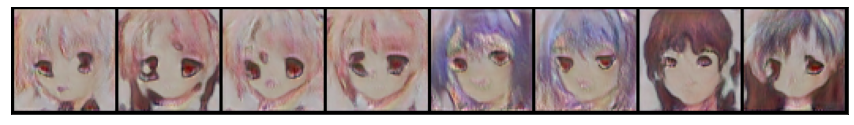

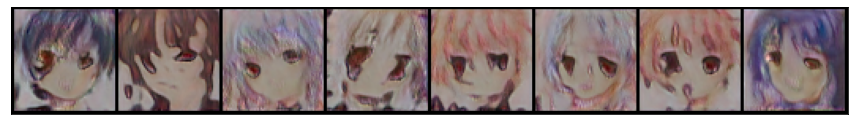

In [5]:
# generate examples
from model import HistoGAN
from utils import random_interpolate_hists
## compute FID Scores for
generator = HistoGAN(config["network_capacity"], 
                     config["latent_dim"], 
                     config["bin_size"], 
                     config["image_res"], 
                     config["mapping_layer_num"], 
                     config["kaiming_init"], 
                     config["use_eqlr"], 
                     config["gen_arch"])
generator.load_state_dict(torch.load(os.path.join(config["save_model_path"], "generator.pt")))
generator = generator.to(trainer.device)
with torch.no_grad():
    for i, data in enumerate(trainer.dataloader):
        z = torch.randn(trainer.batch_size, trainer.num_gen_layers-2, trainer.latent_dim).to(trainer.device)
        target_hist = random_interpolate_hists(data)
        fake_data, _ = generator(z, target_hist)
        show(make_grid(fake_data, normalize=True))
        if i == 1:
            break

In [6]:
# Compute FID Scores
from eval import fid_scores

generator = generator.to("cpu")
fids = fid_scores(generator, trainer.dataloader, fid_batch=trainer.batch_size, 
                  num_gen_layers=trainer.num_gen_layers, latent_dim=trainer.latent_dim, mixing_prob=trainer.mixing_prob,  device="cpu")
fid_np = np.array(fids)
print("FID Score:", fid_np.mean())

/home/kovan/anaconda3/envs/histo/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FID Score: 230.82811091496393


In [7]:
## Compute divegences and losses for histogram quality comparison
from eval import hist_uv_h, hist_uv_kl, interpret
generator = generator.to("cpu")

kls = hist_uv_kl(generator, trainer.dataloader, kl_batch=trainer.batch_size, 
                  num_gen_layers=trainer.num_gen_layers, latent_dim=trainer.latent_dim, mixing_prob=trainer.mixing_prob,  device="cpu")
kl_np = np.array(kls)
print("KL divergence between histograms of generated and target images:", kl_np.mean())

hist_dists = hist_uv_h(generator, trainer.dataloader, h_batch=trainer.batch_size, 
                  num_gen_layers=trainer.num_gen_layers, latent_dim=trainer.latent_dim, mixing_prob=trainer.mixing_prob,  device="cpu")
hd_np = np.array(hist_dists)
print("Helliger Loss between generated and target images:", hd_np.mean())

KL divergence between histograms of generated and target images: 3.0963476
Helliger Loss between generated and target images: 0.47625652


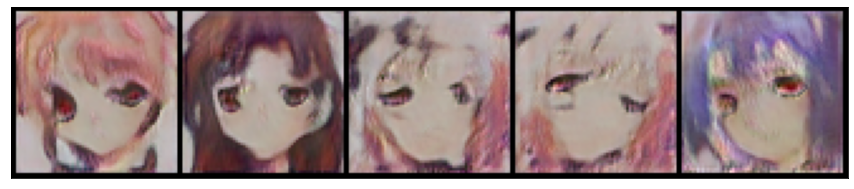

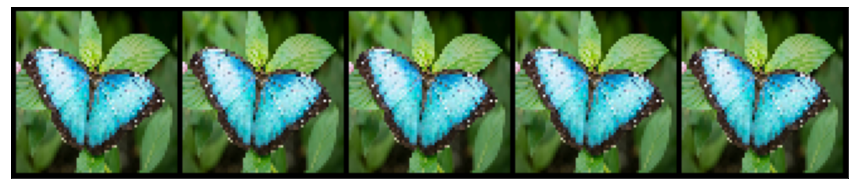

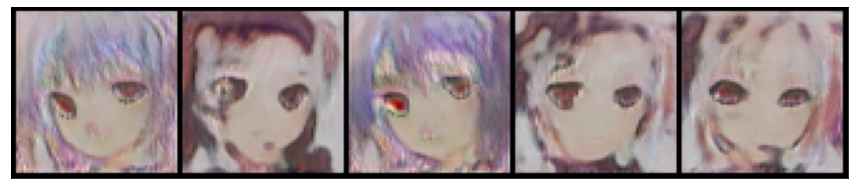

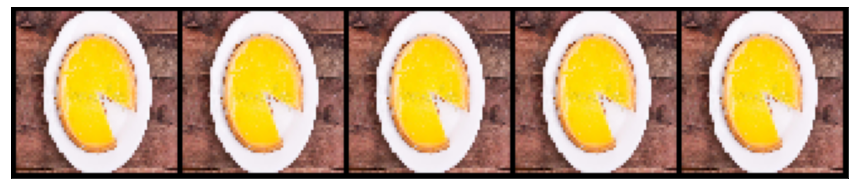

In [13]:
# Tried to control the color scheme of the generated images using the histogram but it fails
fake, target  = interpret(generator, "bluebutterfly.jpg", config["image_res"])
show(make_grid(fake, normalize=True))
show(make_grid(target, normalize=True))
fake, target  = interpret(generator, "lemoncheesecake.jpg", config["image_res"])
show(make_grid(fake, normalize=True))
show(make_grid(target, normalize=True))

### Summary of Work Done
At Milestone1:
- We implemented histogram computations and histogram loss.
- We build HistoGAN network, which is slightly different version of StyleGAN2.
- We implemented evaluation metrics, but could not try because of poor learning.
- We implemented WGAN loss and Non-saturating loss but could not reach good performance.
- We trained without target histogram, i.e. just aimed to create anime characters.
- We switch to 64x64 generations for faster training.

At Milestone2:
- We implemeted different GAN loss functions.
- We trained with different optimizers Adam and DiffGrad.
- We trained with accumulated gradients with bathc size is 2 and accumulation is 16 loops. Yet, it give worse performace than no accumulation with batch of 16 images. Thus, we stick with 64x64 images with batch of 16.
- We trained with target histogram (unlike at MS1).
- We implemented StyleGAN and StyleGAN-rewised in order to investigate errors in modulation/demodulation on the weights. Remember that StyleGAN version 1 modulates the input, not the weights.

Future work:
- New constant for histogram loss as we saw that model does not care histogram target.
- Longer training
- Hyperparameter search as we changed loss functions.
